In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random 
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.applications import VGG16
from keras.utils import plot_model
from keras.layers import Dropout, Flatten, Dense
from keras.activations import relu,softmax
from keras.models import Model,load_model
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint

In [2]:

image_path = "./input/train/"
filenames = os.listdir(image_path)
class_of_img = [x.split(".")[0] for x in filenames ]
df = pd.DataFrame({
    'filename' : filenames,
    'label' : class_of_img,
})

df.describe()


,filename,label
count,25000,25000
unique,25000,2
top,cat.0.jpg,cat
freq,1,12500


In [3]:
df["filename"].count()

25000

In [4]:
df["label"].value_counts()

label
cat    12500
dog    12500
Name: count, dtype: int64

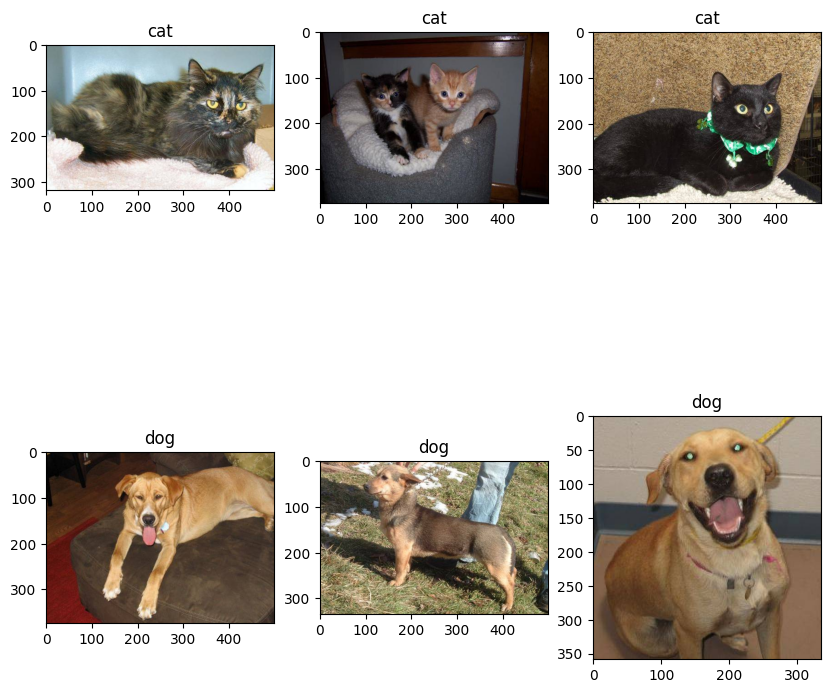

In [5]:
grouped_data = df.groupby("label")
max_img = 3

fig, axis = plt.subplots(len(grouped_data), max_img, figsize=(10,10))

for i,(category, dataframe) in enumerate(grouped_data):
    
    random_indices = random.sample(range(len(dataframe)), max_img)
    
    for j, index in enumerate(random_indices):
        filename = dataframe.iloc[index]["filename"]
        filepath = os.path.join("./input/train/",filename)
        image = Image.open(filepath)
        axis[i, j].imshow(image)
        axis[i, j].set_title(category)

In [6]:
image_heights = []
image_widths = []

for i in df["filename"]:
    i = cv2.imread(os.path.join(image_path,i))
    (hgt, wid, _) = i.shape
    image_heights.append(hgt)
    image_widths.append(wid)

image_height_median = np.median(image_heights)
image_width_median = np.median(image_widths)

print(f"Median : {image_height_median} X {image_width_median}")

Median : 374.0 X 447.0


In [7]:
labels = df["label"]

x_train,x_test = train_test_split(df,stratify=labels,test_size=0.2)

test_labels = x_test["label"]

x_val, x_test = train_test_split(x_test,stratify=test_labels,test_size=0.5)

print("Training data : ",x_train["label"].value_counts())
print("Testing data : ",x_test["label"].value_counts())
print("Validation data : ",x_val["label"].value_counts())

Training data :  label
dog    10000
cat    10000
Name: count, dtype: int64
Testing data :  label
dog    1250
cat    1250
Name: count, dtype: int64
Validation data :  label
cat    1250
dog    1250
Name: count, dtype: int64


In [8]:
batch_size = 16
size = (370, 370)
idg = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
train_gen = idg.flow_from_dataframe(dataframe=x_train,
                                    directory="./input/train",
                                    x_col="filename",
                                    y_col="label",
                                    target_size=size,
                                    batch_size=batch_size,
                                    validate_filenames=True)

Found 20000 validated image filenames belonging to 2 classes.


In [10]:
test_gen = idg.flow_from_dataframe(dataframe=x_test,
                                    directory="./input/train",
                                    x_col="filename",
                                    y_col="label",
                                    target_size=size,
                                    batch_size=batch_size,
                                    validate_filenames=True)

Found 2500 validated image filenames belonging to 2 classes.


In [11]:
val_gen = idg.flow_from_dataframe(dataframe=x_val,
                                    directory="./input/train",
                                    x_col="filename",
                                    y_col="label",
                                    target_size=size,
                                    batch_size=batch_size,
                                    validate_filenames=True)

Found 2500 validated image filenames belonging to 2 classes.


In [12]:
vgg_model = VGG16(include_top=False,
                  input_shape=(370,370,3))

In [13]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370, 370, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0     

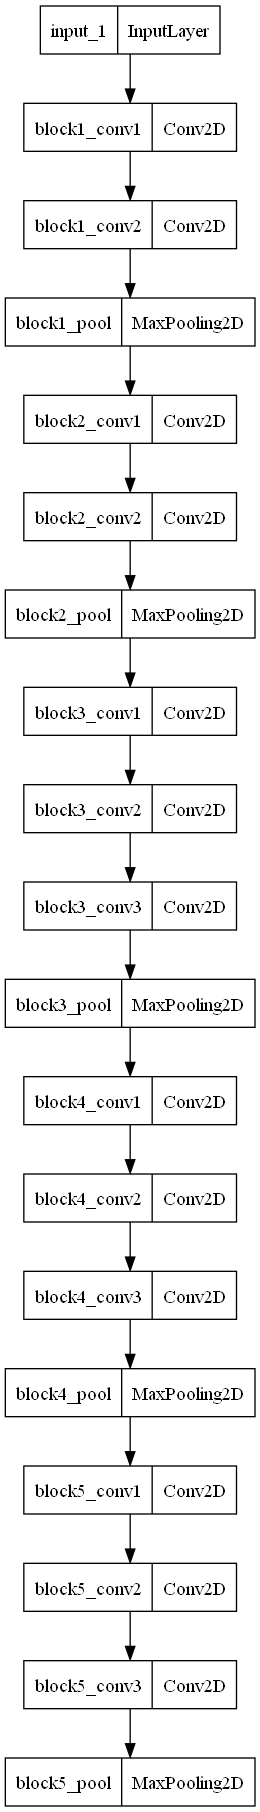

In [14]:
plot_model(vgg_model)

In [15]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370, 370, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0     

In [16]:
for i in vgg_model.layers:
    i.trainable = False
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370, 370, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0     

In [17]:
flatten = Flatten() (vgg_model.output)
dropout1 = Dropout(0.2, name="dropout1") (flatten)
# dense = Dense(128,activation=relu) (dropout1)
# dropout2 = Dropout(0.2, name="dropout2")(dense)
output = Dense(2,activation=softmax) (dropout1)

final_model = Model(inputs=[vgg_model.input], outputs=[output])
final_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 370, 370, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 370, 370, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 370, 370, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 185, 185, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 185, 185, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 185, 185, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 92, 92, 128)       0     

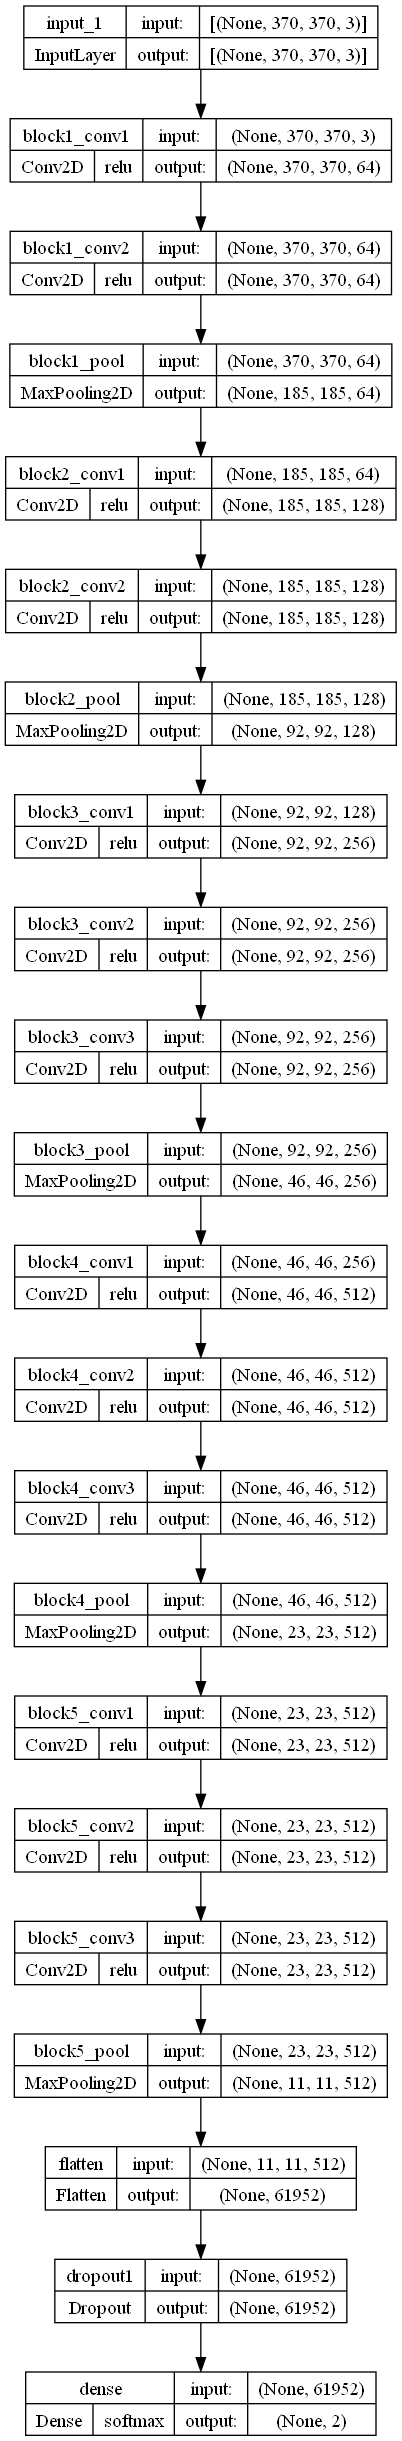

In [18]:
plot_model(final_model,
           show_shapes=True,
           show_layer_names=True,
           show_layer_activations=True)

In [19]:
final_model.compile(optimizer="adam",
                    loss=categorical_crossentropy,
                    metrics=['acc'])

In [20]:
ckpt = ModelCheckpoint("ckpt",
                       save_best_only=True,
                       monitor="val_acc")

In [21]:
hist = final_model.fit(train_gen,
                       batch_size=batch_size,
                       epochs=10,
                       callbacks=[ckpt],
                       validation_data=val_gen)

Epoch 1/10
  26/1250 [..............................] - ETA: 18:55 - loss: 5.1438 - acc: 0.8750

In [ ]:
final_model.save("./output/model.h5")

ValueError: x and y must have same first dimension, but have shapes (8,) and (10,)

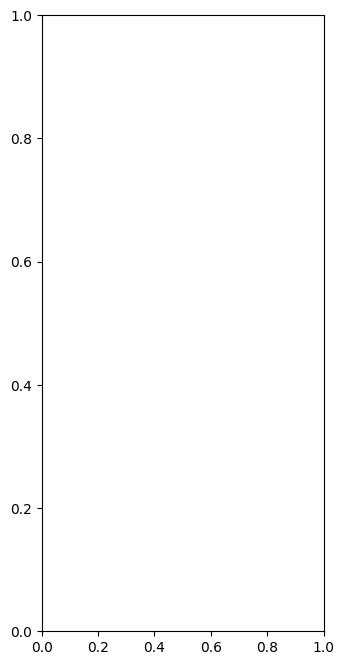

In [ ]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cat_dog_model = load_model("DogCat")
result = cat_dog_model.predict(test_gen)
result_argmax = np.argmax(result, axis=1)
y_true = test_gen.labels
y_pred = result_argmax
accuracy = (y_pred == y_true).mean()

print("Test Accuracy:", accuracy)